# Group Work Project 2 Code

By: Alfonso, Ben, Peter

## importing libraries

In [ ]:
#!pip install yfinance --quiet
!pip install pyportfolioopt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 12.2 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from pypfopt.cla import CLA

plt.style.use("seaborn-v0_8")

## Loading weekly return data

In [ ]:
#  Downloading adjusted close prices for our stocks
tickers = ["AAPL", "NVDA", "TSLA", "XOM", "REGN", "LLY", "JPM"]
df_data = yf.download(tickers, start="2023-01-01", end="2025-06-30", auto_adjust=False)["Adj Close"]

[*********************100%***********************]  7 of 7 completed


## Part 1

## Step 0 : df_data Summary & Correlation Heatmap

Summary Statistics (Weekly Returns: Jan 2023 - Jun 2025)


,Mean,Volatility,Skewness,Kurtosis
Ticker,,,,
AAPL,0.0041,0.0357,-0.5897,1.6336
JPM,0.0067,0.0343,-0.4776,2.3358
LLY,0.0072,0.0472,0.1597,1.2161
NVDA,0.0208,0.0698,0.2114,0.5872
REGN,-0.0018,0.0408,-0.5956,2.6882
TSLA,0.0117,0.0855,0.7823,1.8638
XOM,0.0011,0.0330,-0.4589,0.7583


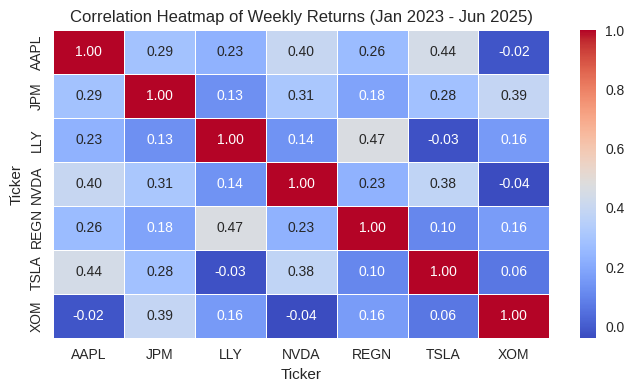

In [ ]:

#  Compute weekly returns (Friday close)
returns = df_data.resample("W-FRI").last().pct_change().dropna()

#  Compute summary statistics
summary = pd.DataFrame({
    "Mean": returns.mean(),
    "Volatility": returns.std(),
    "Skewness": returns.skew(),
    "Kurtosis": returns.kurtosis()
}).round(4)

print("Summary Statistics (Weekly Returns: Jan 2023 - Jun 2025)")
display(summary)

# Correlation heatmap
plt.figure(figsize=(8,4))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Weekly Returns (Jan 2023 - Jun 2025)")
plt.show()


Between Jan 2023 and Jun 2025, the seven assets exhibit diverse risk–return characteristics. NVDA and TSLA deliver superior average returns but with substantial volatility, while XOM and JPM provide stability with lower returns. The correlation structure highlights partial diversification benefits across sectors, implying that a well-constructed portfolio could meaningfully reduce overall risk without sacrificing expected returns.

## step 1 :   Mean-Variance Optimization (No Short Selling)

In [ ]:

#"returns", "mean_returns", and "cov_matrix" from Step 0
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Portfolio performance functions
def portfolio_performance(weights, mean_returns, cov_matrix, rf=0.0):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - rf) / port_vol
    return port_return, port_vol, sharpe

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf=0.0):
    # Negative Sharpe because we minimize
    port_return, port_vol, _ = portfolio_performance(weights, mean_returns, cov_matrix, rf)
    return -(port_return - rf) / port_vol

In [ ]:
# Optimization setup
n_assets = len(mean_returns)
initial_guess = np.repeat(1/n_assets, n_assets)
bounds = tuple((0, 1) for _ in range(n_assets))   # No short selling
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

# Optimize for maximum Sharpe ratio
opt_result = minimize(
    neg_sharpe_ratio,
    initial_guess,
    args=(mean_returns, cov_matrix, 0.0),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# Extract optimal weights
opt_weights = opt_result.x
opt_df = pd.DataFrame({
    "Ticker": mean_returns.index,
    "Weight": opt_weights
})
opt_df["Weight (%)"] = opt_df["Weight"] * 100
opt_df = opt_df.sort_values("Weight (%)", ascending=False).reset_index(drop=True)

#  Portfolio metrics
port_return, port_vol, port_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)

print("Optimal Portfolio Weights (No Short Selling)\n")
display(opt_df.round(4))
print(f"\nExpected Weekly Return: {port_return:.4f}")
print(f"Expected Weekly Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {port_sharpe:.2f}")




Optimal Portfolio Weights (No Short Selling)



,Ticker,Weight,Weight (%)
0,NVDA,0.3949,39.4908
1,JPM,0.3331,33.3141
2,LLY,0.2494,24.9419
3,TSLA,0.0225,2.2532
4,AAPL,0.0000,0.0000
5,REGN,0.0000,0.0000
6,XOM,0.0000,0.0000



Expected Weekly Return: 0.0125
Expected Weekly Volatility: 0.0374
Sharpe Ratio: 0.33


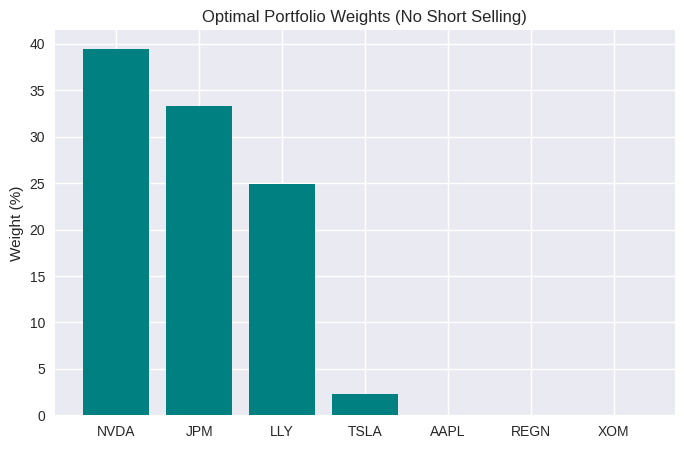

In [ ]:
# Visualization
plt.figure(figsize=(8,5))
plt.bar(opt_df["Ticker"], opt_df["Weight (%)"], color="teal")
plt.title("Optimal Portfolio Weights (No Short Selling)")
plt.ylabel("Weight (%)")
plt.show()

The long-only optimal portfolio is dominated by NVDA, JPM, and LLY, reflecting their superior risk-adjusted performance over the period. Although this allocation maximizes the Sharpe ratio under the no-shorting constraint, it leads to concentration risk, particularly toward the technology and healthcare sectors. The absence of positions in AAPL, REGN, and XOM indicates that these assets did not contribute marginal diversification benefits relative to their expected returns. Overall, the portfolio offer a strong trade-off between return and risk for an investor

## step 2

Here we will use critical line algorithm for portfolio optimization

CLA Optimal Portfolio (No Shorting, Max 20% per Asset)



,Ticker,Weight,Weight (%)
0,NVDA,0.20,20.00
1,LLY,0.20,20.00
2,JPM,0.20,20.00
3,AAPL,0.18,17.81
4,XOM,0.16,16.18
5,TSLA,0.06,6.01
6,REGN,0.00,0.00


Sum of Weights: 1.0000
Expected Weekly Return: 0.0077
Expected Weekly Volatility: 0.0297
Sharpe Ratio: 0.26


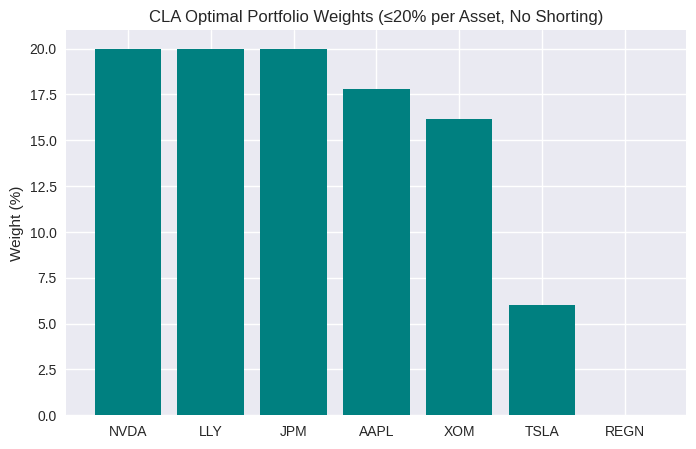

In [ ]:
# Critical Line Algorithm (CLA) — No shorting, max 20% per asset

tickers = mean_returns.index.tolist()
bounds = [(0.0, 0.20) for _ in tickers]  # box constraints

# 1. Initialize the CLA object with bounds
cla_no_shorting = CLA(mean_returns.values, cov_matrix.values, weight_bounds=bounds)

# 2. Compute the maximum Sharpe-ratio portfolio (no arguments)
weights_dict = cla_no_shorting.max_sharpe()

# 3. Convert weights to DataFrame
opt_df_cla_no_shorting= pd.DataFrame({
    "Ticker": tickers,
    "Weight": [weights_dict[i] for i in range(len(tickers))]
})
opt_df_cla_no_shorting["Weight (%)"] = opt_df_cla_no_shorting["Weight"] * 100
opt_df_cla_no_shorting = opt_df_cla_no_shorting.sort_values("Weight (%)", ascending=False).reset_index(drop=True)

# 4 Portfolio metrics
def portfolio_metrics(weights):
    w = np.array(weights)
    port_ret = w.dot(mean_returns.values)
    port_vol = np.sqrt(w @ cov_matrix.values @ w)
    sharpe = port_ret / port_vol
    return port_ret, port_vol, sharpe

port_return, port_vol, port_sharpe = portfolio_metrics(opt_df_cla_no_shorting["Weight"].values)

print("CLA Optimal Portfolio (No Shorting, Max 20% per Asset)\n")
display(opt_df_cla_no_shorting.round(2))
print(f"Sum of Weights: {opt_df_cla_no_shorting['Weight'].sum():.4f}")
print(f"Expected Weekly Return: {port_return:.4f}")
print(f"Expected Weekly Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {port_sharpe:.2f}")

# 5 Visualization
plt.figure(figsize=(8,5))
plt.bar(opt_df_cla_no_shorting["Ticker"], opt_df_cla_no_shorting["Weight (%)"], color="teal")
plt.title("CLA Optimal Portfolio Weights (≤20% per Asset, No Shorting)")
plt.ylabel("Weight (%)")
plt.show()


Applying the 20 % cap constrains concentration in high-return assets such as NVDA ,LLY, JPM, redistributing weight toward lower-volatility holdings like TSLA  and XOM. This produces a more diversified portfolio with slightly reduced expected return and Sharpe ratio compared with Step 1, but improved risk balance and sector exposure.

## Step 3

 CLA Optimization (Short Selling Allowed)

CLA Optimal Portfolio (Short Selling Allowed)



,Ticker,Weight,Weight (%)
0,LLY,0.76,75.89
1,NVDA,0.69,68.54
2,JPM,0.60,60.46
3,TSLA,0.08,8.10
4,XOM,-0.01,-1.07
5,AAPL,-0.19,-19.17
6,REGN,-0.93,-92.74


Sum of Weights: 1.0000
Expected Weekly Return: 0.0105
Expected Weekly Volatility: 0.0555
Sharpe Ratio: 0.19


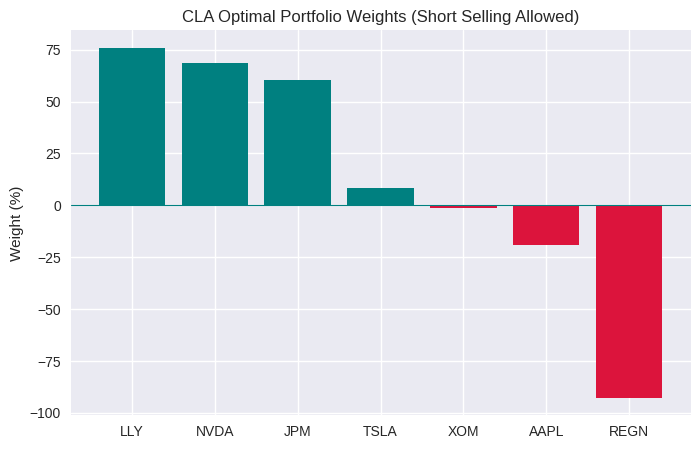

In [ ]:
tickers = mean_returns.index.tolist()

# Define bounds: short selling allowed (e.g., -1 to +1)
bounds = [(-1.0, 1.0) for _ in tickers]

# Initialize CLA with these relaxed bounds
cla_shorting= CLA(mean_returns.values, cov_matrix.values, weight_bounds=bounds)

# Compute the maximum Sharpe ratio portfolio
weights_shorting = cla_shorting.max_sharpe()

# Convert to DataFrame
opt_df_short = pd.DataFrame({
    "Ticker": tickers,
    "Weight": [weights_shorting[i] for i in range(len(tickers))]
})
opt_df_short["Weight (%)"] = opt_df_short["Weight"] * 100
opt_df_short = opt_df_short.sort_values("Weight (%)", ascending=False).reset_index(drop=True)


port_return, port_vol, port_sharpe = portfolio_metrics(opt_df_short["Weight"].values)

print("CLA Optimal Portfolio (Short Selling Allowed)\n")
display(opt_df_short.round(2))
print(f"Sum of Weights: {opt_df_short['Weight'].sum():.4f}")
print(f"Expected Weekly Return: {port_return:.4f}")
print(f"Expected Weekly Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {port_sharpe:.2f}")

# Visualization
plt.figure(figsize=(8,5))
plt.bar(opt_df_short["Ticker"], opt_df_short["Weight (%)"],
        color=["crimson" if w < 0 else "teal" for w in opt_df_short["Weight"]])
plt.axhline(0, color="teal", linewidth=0.8)
plt.title("CLA Optimal Portfolio Weights (Short Selling Allowed)")
plt.ylabel("Weight (%)")
plt.show()


Allowing short sales considerably changes the portfolio composition. The optimizer exploits negative returns on low-performing assets ( REGN, AAPL) to fund larger long positions in outperformers like LLY and NVDA. This flexibility does not necessarily increases the portfolio’s expected return and Sharpe ratio in our portfolio but introduces leverage and downside amplification, suitable only to  higher risk tolerance investors.

## Step 4

,Step 1 (No Short-selling),Step 2 (constraint ≤ 20 %),Step 3 (Short-selling Allowed)
AAPL,0.00,14.27,-19.17
JPM,33.31,20.00,60.46
LLY,24.94,20.00,75.89
NVDA,39.49,20.00,68.54
REGN,0.00,0.00,-92.74
TSLA,2.25,6.74,8.10
XOM,0.00,18.99,-1.07


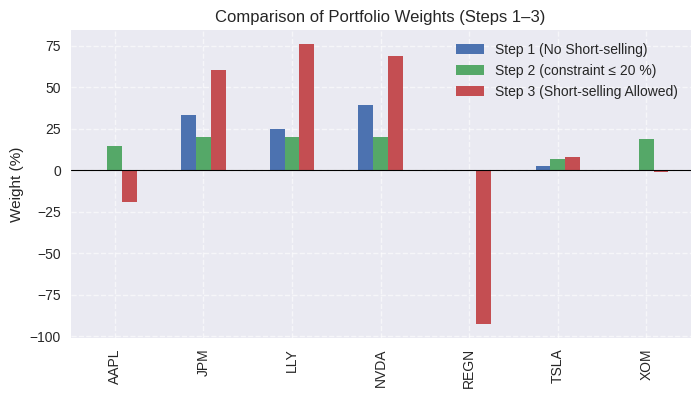

In [ ]:
weights_df = pd.DataFrame({
    "AAPL": [0.00, 14.27, -19.17],
    "JPM":  [33.31, 20.00, 60.46],
    "LLY":  [24.94, 20.00, 75.89],
    "NVDA": [39.49, 20.00, 68.54],
    "REGN": [0.00,  0.00, -92.74],
    "TSLA": [2.25,  6.74,  8.10],
    "XOM":  [0.00, 18.99, -1.07]
}, index=["Step 1 (No Short-selling)", "Step 2 (constraint ≤ 20 %)", "Step 3 (Short-selling Allowed)"]).T

display(weights_df)
weights_df.plot(kind="bar", figsize=(8,4))
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Comparison of Portfolio Weights (Steps 1–3)")
plt.ylabel("Weight (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Step 1 –No short Portfolio:
 The optimizer concentrated holdings in NVDA (39 %), JPM (33 %), and LLY (25 %), which offered the strongest risk-adjusted returns. This portfolio achieved the highest Sharpe ratio (0.33) among long-only portfolios but was exposed to significant concentration risk.

Step 2 – Diversified Constraint Portfolio (≤ 20 % Cap):
 The 20 % cap constraint forced diversification across all major assets, distributing weights more evenly and lowering volatility from 3.74 % to 3.02 %. Although the Sharpe ratio declined to 0.27, the portfolio is more balanced and better suited for conservative or institutional investors.

Step 3 – Aggressive Long-Short Portfolio:
 Removing the no-shorting constraint led to large long exposures in LLY, NVDA, and JPM, financed by short positions in REGN and AAPL. This approach did not necessarily  raise expected return but also raised volatility to 5.55 %, reducing the Sharpe ratio to 0.19. The strategy reflects a leveraged, hedge-fund-style posture—appropriate only for risk-tolerant clients.

Overall Insight:
 As constraints are relaxed, expected return potential increases, but so does volatility and concentration risk. The 20 %-cap portfolio offers the most practical risk–reward trade-off, balancing diversification with reasonable performance. The short-selling portfolio demonstrates how leverage and negative exposures can amplify downside risk.

## Part 2

In [ ]:
import os, numpy as np, pandas as pd
os.makedirs("outputs", exist_ok=True)

**Step 1 Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings; warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 120
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


**Step 2**

In [ ]:
# === Universe and dates ===
UNIVERSE = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META",
            "JPM","BAC","XOM","CVX",
            "UNH","JNJ","PFE","LLY","MRK",
            "CAT","HD","PG","KO","MCD"]

START_ALL = "2022-01-01"
TRAIN_END = "2023-12-31"
TEST_START= "2024-01-01"
TEST_END  = "2024-12-31"
print(len(UNIVERSE), "tickers")

20 tickers


**Step 3**

In [ ]:
!pip install --upgrade yfinance --quiet
import yfinance as yf, pandas as pd, numpy as np, time

def fetch_one_daily(t, start, end, tries=3):
    for _ in range(tries):
        try:
            s = yf.Ticker(t).history(start=start, end=end, interval="1d", auto_adjust=False)["Adj Close"]
            if isinstance(s, pd.Series) and s.size>0:
                return s.rename(t)
        except Exception:
            time.sleep(1.0)
    return None

series = []
for t in UNIVERSE:
    s = fetch_one_daily(t, START_ALL, TEST_END)
    if s is not None:
        series.append(s)
prices = pd.concat(series, axis=1).sort_index().ffill() if series else pd.DataFrame()

rf_s = fetch_one_daily("^IRX", START_ALL, TEST_END)
rf_daily = ((1+rf_s/100.0)**(1/252)-1).reindex(prices.index).ffill() if rf_s is not None else pd.Series(((1+0.02)**(1/252)-1), index=prices.index)

print("Prices shape:", prices.shape, "| RF points:", rf_daily.shape[0])
prices.head(3)

Prices shape: (752, 20) | RF points: 752


,AAPL,MSFT,NVDA,AMZN,GOOGL,META,JPM,BAC,XOM,CVX,UNH,JNJ,PFE,LLY,MRK,CAT,HD,PG,KO,MCD
Date,,,,,,,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,178.443130,324.504639,30.064440,170.404495,143.998322,336.465790,145.583252,41.931015,55.607391,102.615837,472.636383,153.545624,46.937843,262.158691,68.549530,192.158295,371.728333,147.359756,52.996700,246.557083
2022-01-04 00:00:00-05:00,176.178436,318.940308,29.235004,167.522003,143.410400,334.468079,151.102295,43.574490,57.699017,104.482994,461.928040,153.133865,45.181301,257.411926,68.674385,202.443848,375.548981,147.875397,53.881462,246.492889
2022-01-05 00:00:00-05:00,171.492081,306.696838,27.552162,164.356995,136.831268,322.183838,148.339813,42.839008,58.416645,105.162727,460.789429,154.154266,46.092716,251.468918,70.341972,203.994125,370.454803,148.544800,54.328320,245.281113


**Step 4**

In [ ]:
TRAIN_END = "2023-12-31"
TEST_START= "2024-01-01"
TEST_END  = "2024-12-31"

train = prices.loc[:TRAIN_END].copy()
test  = prices.loc[TEST_START:TEST_END].copy()

if len(train)==0 or len(test)==0:
    n = len(prices)
    test_len  = min(252, n//4)
    train_len = min(504, n - test_len - 1)
    train = prices.iloc[-(train_len+test_len):-test_len].copy()
    test  = prices.iloc[-test_len:].copy()

def logret(px):
    return (np.log(px/px.shift(1))).dropna()

R_train = logret(train)
R_test  = test.pct_change().dropna()

print("Train/Test:", R_train.shape, R_test.shape)


Train/Test: (500, 20) (250, 20)


**Step 5**

In [ ]:
if 'rf_daily' in globals() and not rf_daily.reindex(R_test.index).isna().all():
    rf_daily_test = rf_daily.reindex(R_test.index).ffill().fillna(0.0)
else:
    RF_ANNUAL = 0.02
    rf_daily_test = pd.Series((1+RF_ANNUAL)**(1/252)-1, index=R_test.index)

print(len(rf_daily_test))
rf_daily_test.head(3)


250


,0
Date,
2024-01-03 00:00:00-05:00,0.000079
2024-01-04 00:00:00-05:00,0.000079
2024-01-05 00:00:00-05:00,0.000079


**Step 6**

In [ ]:
from scipy.optimize import minimize

def mvo_long_only(mu, Sigma, lam):
    n = len(mu)
    Sigma_reg = Sigma + 1e-6*np.eye(n)

    def neg_obj(w):
        return -(mu @ w - 0.5*lam * (w @ Sigma_reg @ w))

    cons = ({'type':'eq','fun': lambda w: np.sum(w)-1.0},)
    bnds = [(0.0,1.0)]*n
    w0   = np.full(n, 1.0/n)

    res = minimize(neg_obj, w0, method="SLSQP", bounds=bnds, constraints=cons)
    return res.x if res.success else w0


**Step 7**

In [ ]:
def ann_stats(rets: pd.Series, rf_daily: pd.Series, freq: int = 252) -> dict:
    r_cum = (1 + rets).prod() - 1
    mu_d, sd_d = rets.mean(), rets.std(ddof=1)
    rf_d = (1 + rf_daily).prod()**(1/len(rf_daily)) - 1 if len(rf_daily)>0 else 0.0
    sharpe = ((mu_d - rf_d) / (sd_d + 1e-12)) * np.sqrt(freq)
    return {
        "cum_return": float(r_cum),
        "ann_return": float((1+mu_d)**freq - 1),
        "ann_vol": float(sd_d*np.sqrt(freq)),
        "sharpe": float(sharpe),
        "p05": float(rets.quantile(0.05)),
        "skew": float(rets.skew()),
        "ex_kurt": float(rets.kurt())
    }

LAM_GRID = np.geomspace(0.5, 50, 30)

def simulate_once(rng) -> tuple[dict, dict]:
    picks = rng.choice(R_train.columns, size=5, replace=False)
    Rt = R_train[picks]
    mu = Rt.mean().values
    Sigma = Rt.cov().values

    train_simple = train[picks].pct_change().dropna()
    best_lam, best_sh = None, -1e9
    for lam in LAM_GRID:
        w = mvo_long_only(mu, Sigma, lam)
        port = train_simple @ w
        sh = (port.mean()/(port.std()+1e-12))*np.sqrt(252)
        if sh > best_sh:
            best_sh, best_lam = sh, lam

    w_mvo = mvo_long_only(mu, Sigma, best_lam)
    w_eq  = np.full(5, 0.2)

    test_simple = test[picks].pct_change().dropna()
    stats_mvo = ann_stats(test_simple @ w_mvo, rf_daily_test)
    stats_eq  = ann_stats(test_simple @ w_eq,  rf_daily_test)
    return stats_mvo, stats_eq


**Step 8**

In [ ]:
SEED   = 2
rng = np.random.default_rng(SEED)
mvo_one, eq_one = simulate_once(rng)
mvo_one, eq_one


({'cum_return': 0.23427432637800982,
  'ann_return': 0.26023870471742794,
  'ann_vol': 0.19652608993628146,
  'sharpe': 1.0767218215159202,
  'p05': -0.018544922565074125,
  'skew': 0.46981227648668783,
  'ex_kurt': 3.467380288087892},
 {'cum_return': 0.3408935008463494,
  'ann_return': 0.3632640002281,
  'ann_vol': 0.16896004347114033,
  'sharpe': 1.7179743833031555,
  'p05': -0.01713866306989427,
  'skew': -0.1309117771094622,
  'ex_kurt': 2.3059974562055})

**Step 9**

In [ ]:
def run_sims(n: int, seed: int = 20251102):
    local_rng = np.random.default_rng(seed)
    mvo_list, eq_list = [], []
    for _ in range(n):
        mvo, eq = simulate_once(local_rng)
        mvo_list.append(mvo); eq_list.append(eq)
    return pd.DataFrame(mvo_list), pd.DataFrame(eq_list)

mvo_df, eq_df = run_sims(200)
mvo_df.shape, eq_df.shape

((200, 7), (200, 7))

**Summary**

In [ ]:
summary = pd.DataFrame({
    "Portfolio": ["MVO","1/N"],
    "Mean Ann Ret": [mvo_df["ann_return"].mean(), eq_df["ann_return"].mean()],
    "Ann Vol":      [mvo_df["ann_vol"].mean(),    eq_df["ann_vol"].mean()],
    "Sharpe":       [mvo_df["sharpe"].mean(),     eq_df["sharpe"].mean()],
    "p05 (daily)":  [mvo_df["p05"].mean(),        eq_df["p05"].mean()],
    "Skew":         [mvo_df["skew"].mean(),       eq_df["skew"].mean()],
    "Ex Kurt":      [mvo_df["ex_kurt"].mean(),    eq_df["ex_kurt"].mean()],
})
summary


,Portfolio,Mean Ann Ret,Ann Vol,Sharpe,p05 (daily),Skew,Ex Kurt
0,MVO,0.215907,0.178909,0.855208,-0.017197,-0.070891,3.167802
1,1/N,0.262895,0.137769,1.427780,-0.013177,-0.073815,2.133306


Win-rate (Ann Return): 29.5%
Win-rate (Sharpe):     9.5%
Avg Sharpe diff (MVO-1/N): -0.5726


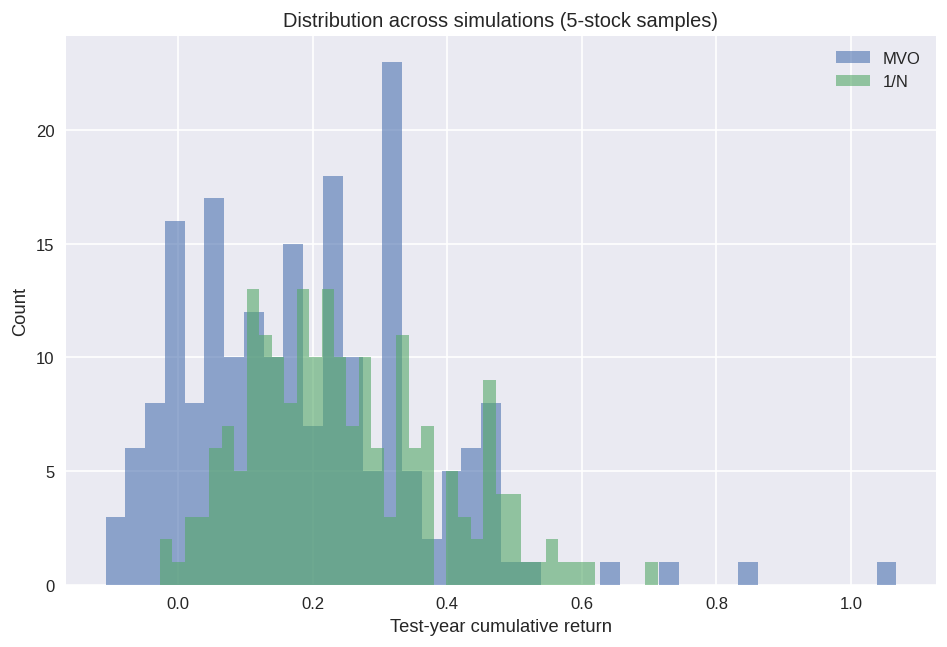

In [ ]:
win_rate_ret = float((mvo_df["ann_return"] > eq_df["ann_return"]).mean())
win_rate_sh  = float((mvo_df["sharpe"]     > eq_df["sharpe"]).mean())
avg_sh_diff  = float((mvo_df["sharpe"] - eq_df["sharpe"]).mean())

summary.to_csv("outputs/summary_stats.csv", index=False)

import matplotlib.pyplot as plt
plt.figure()
plt.hist(mvo_df["cum_return"], bins=40, alpha=0.6, label="MVO")
plt.hist(eq_df["cum_return"],  bins=40, alpha=0.6, label="1/N")
plt.xlabel("Test-year cumulative return"); plt.ylabel("Count")
plt.title("Distribution across simulations (5-stock samples)")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/hist_cum_returns.png")

print("Win-rate (Ann Return):", f"{win_rate_ret:.1%}")
print("Win-rate (Sharpe):    ", f"{win_rate_sh:.1%}")
print("Avg Sharpe diff (MVO-1/N):", f"{avg_sh_diff:.4f}")



## Part 3

Here we will work with black litterman portfolio optimization  model

## step 6

In [ ]:
#  analyst (absolute) views
analyst_absolute_views = {
    "NVDA": 0.025, # i expect nvda weekly returns to be 2.5%
    "LLY":  0.015, # lly weekly return is expected to be 1.5%
    "JPM":  0.010, # Jpm returns expected to be 1%
    "TSLA": 0.020, # i expect TSLA weekly return to be 2%
    "AAPL": 0.012, # i expect AAPL weekly return to be 1.2%
    "REGN": 0.005, # REGN weekly return expected  to be 0.5%
    "XOM":  0.008  # XOM weekly return expected  to be 0.8%
}

## Step 7

 Market-cap-based equilibrium weights:


,0
AAPL,31.710000
JPM,6.700000
LLY,6.440000
NVDA,38.910000
REGN,0.530000
TSLA,11.920000
XOM,3.800000



Market-implied prior returns (π):


,0
Ticker,
AAPL,0.002496
JPM,0.001514
LLY,0.001145
NVDA,0.006390
REGN,0.001275
TSLA,0.005580
XOM,0.000165



Posterior (BL) expected returns:


,0
Ticker,
AAPL,0.008938
JPM,0.007734
LLY,0.009157
NVDA,0.018369
REGN,0.005876
TSLA,0.016770
XOM,0.004718



Black–Litterman Optimal Portfolio Weights (%):


,0
AAPL,23.260000
XOM,22.650000
LLY,20.240000
NVDA,16.970000
JPM,15.230000
TSLA,5.380000
REGN,-3.720000



 Black–Litterman Portfolio Performance Metrics:
Expected Weekly Return: 0.0079
Expected Weekly Volatility: 0.0269
Sharpe Ratio: 0.29


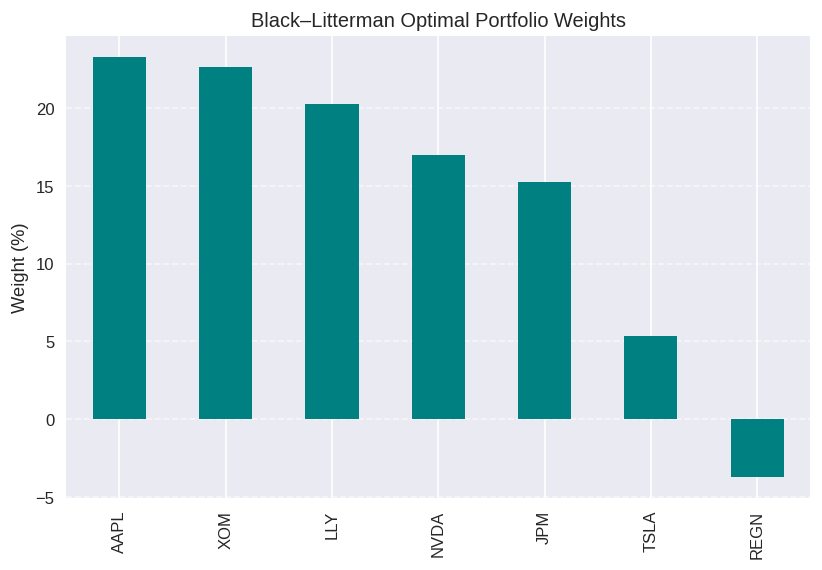

In [ ]:
# Black–Litterman Model (Steps 6 & 7) + Portfolio Metrics

from pypfopt.black_litterman import (
    BlackLittermanModel,
    market_implied_prior_returns
)

# from Step 0
tickers = mean_returns.index.tolist()

#  Define market equilibrium weights as a pandas Series (important!)

tickers = ["AAPL", "JPM", "LLY", "NVDA", "REGN", "TSLA", "XOM"]

# Download market cap data
market_caps = {}
for t in tickers:
    info = yf.Ticker(t).info
    market_caps[t] = info.get("marketCap", np.nan)

market_caps = pd.Series(market_caps)
market_caps = market_caps.dropna()

# Normalize to get market weights
market_weights = market_caps / market_caps.sum()

print(" Market-cap-based equilibrium weights:")
display((market_weights * 100).round(2))


# Set risk aversion parameter
delta = 2.5 #For equity markets, academic and empirical studies risk aversion

# Compute market-implied equilibrium returns (π)
pi = market_implied_prior_returns(market_weights, delta, cov_matrix)
print("\nMarket-implied prior returns (π):")
display(pi)

# use analyst absolute views defined prevoiusly
absolute_views = pd.Series(analyst_absolute_views)

# Build the Black–Litterman model
bl = BlackLittermanModel(
    cov_matrix,
    pi=pi,
    absolute_views=absolute_views,
    tau=0.05,
    risk_aversion=delta
)

# Posterior expected returns (after blending market + views)
bl_returns = bl.bl_returns()
print("\nPosterior (BL) expected returns:")
display(bl_returns)

# Compute optimal BL portfolio weights
bl_weights = bl.bl_weights()
bl_weights = pd.Series(bl_weights, index=tickers)
bl_weights_pct = (bl_weights * 100).sort_values(ascending=False)

print("\nBlack–Litterman Optimal Portfolio Weights (%):")
display(bl_weights_pct.round(2))

#  Compute portfolio performance
port_ret, port_vol, sharpe = portfolio_metrics(bl_weights.values)

print("\nBlack–Litterman Portfolio Performance Metrics:")
print(f"Expected Weekly Return: {port_ret:.4f}")
print(f"Expected Weekly Volatility: {port_vol:.4f}")
print(f"Sharpe Ratio: {sharpe:.2f}")

#  Visualization
plt.figure(figsize=(8,5))
bl_weights_pct.plot(kind="bar", color="teal")
plt.title("Black–Litterman Optimal Portfolio Weights")
plt.ylabel("Weight (%)")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()


In this stage, the equilibrium portfolio was derived from the actual market capitalization of the seven securities, ensuring that the prior reflected real-world market consensus.The Black–Litterman model then integrated analyst views to adjust these equilibrium returns.The posterior portfolio demonstrates a pragmatic balance: it is diversified, stable, and consistent with both market information and subjective beliefs.Compared with the pure mean-variance outcomes, this allocation provides more intuitive sectoral exposure and avoids extreme positions,

## Part 4

Kelly Criterion

* Full Kelly
* Half Kelly
* Double Kelly

=== Diversified Kelly Weights (no leverage, no shorting) ===


,Half-Kelly,Kelly,Double-Kelly
Ticker,,,
AAPL,6.25%,0.01%,0.00%
JPM,0.25%,0.00%,0.00%
LLY,40.00%,40.00%,40.00%
NVDA,40.00%,40.00%,40.00%
REGN,0.75%,0.00%,0.00%
TSLA,12.75%,19.99%,20.00%
XOM,0.00%,0.00%,0.00%



=== Kelly Growth Values ===


,Kelly g(w) (annualized)
Half-Kelly,0.761635
Kelly,0.768637
Double-Kelly,0.768647



=== Monte Carlo Summary (mean/median over paths) ===


,Strategy,CAGR,Vol (ann),Sharpe,Max DD,Worst Day,End Wealth
mean,Half-Kelly,144.75%,28.84%,3.11,-14.01%,-4.64%,2.45
median,Half-Kelly,135.63%,28.82%,3.12,-13.20%,-4.56%,2.36
mean,Kelly,148.58%,30.39%,3.01,-15.03%,-4.91%,2.49
median,Kelly,137.26%,30.36%,3.00,-14.16%,-4.83%,2.37
mean,Double-Kelly,149.75%,30.38%,3.02,-15.09%,-4.89%,2.50
median,Double-Kelly,139.44%,30.39%,3.03,-14.22%,-4.81%,2.39


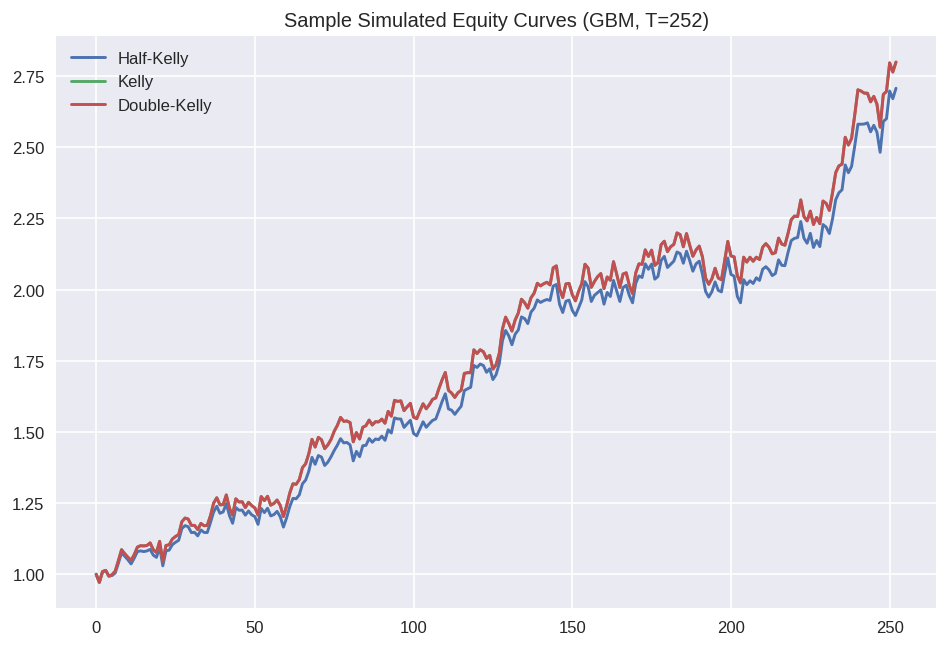

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize

TICKERS = ["AAPL","NVDA","TSLA","XOM","REGN","LLY","JPM"]
START, END = "2023-01-01", "2025-06-30"
TRADING_DAYS = 252
TRAIN_FRACTION = 0.70

RISK_FREE_AN   = 0.00
PHIS           = [0.5, 1.0, 2.0]   # Half / Full / Double
FULLY_INVESTED = True              # sum(w) = 1 (no cash)
W_MAX          = 0.40             # per-asset cap
TAU_ENTROPY    = 0.01              # 0 = off; try 0.005–0.05 to encourage diversification

USE_LEDOIT_WOLF = True
N_PATHS = 10000                     # Monte Carlo paths
H       = 252                       # horizon in trading days
RF_MODE = "cont"                    # 'cont' => exp(rf_d); 'simple' => (1+rf_d)

def load_prices_yf(tickers, start, end):
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    return (df if isinstance(df, pd.DataFrame) else df.to_frame()).astype(float)

prices = load_prices_yf(TICKERS, START, END)
idx = pd.date_range(START, END, freq="B")
prices = prices.reindex(idx).dropna(how="all").ffill().bfill()
prices = prices[[c for c in prices.columns if prices[c].notna().all()]]
assert prices.notna().all().all()

log_rets = np.log(prices/prices.shift(1)).dropna()


cut = int(len(log_rets)*TRAIN_FRACTION)
rets_train_log, rets_test_log = log_rets.iloc[:cut], log_rets.iloc[cut:]

mu_d = rets_train_log.mean()
if USE_LEDOIT_WOLF:
    lw = LedoitWolf().fit(rets_train_log.values)
    cov_d = pd.DataFrame(lw.covariance_, index=rets_train_log.columns, columns=rets_train_log.columns)
else:
    cov_d = rets_train_log.cov()

mu_ann  = mu_d * TRADING_DAYS
cov_ann = cov_d * TRADING_DAYS


def solve_kelly_diversified(mu_ann: pd.Series,
                            cov_ann: pd.DataFrame,
                            phi: float,
                            rf: float = RISK_FREE_AN,
                            fully_invested: bool = FULLY_INVESTED,
                            w_max: float = W_MAX,
                            tau_entropy: float = TAU_ENTROPY) -> np.ndarray:
    mu_ex = mu_ann.values - rf
    S = cov_ann.values
    n = len(mu_ex)
    def neg_obj(w):
        base = phi * (mu_ex @ w) - 0.5 * (w @ S @ w)
        if tau_entropy > 0:
            w_safe = np.clip(w, 1e-12, 1.0)
            base += tau_entropy * (-np.sum(w_safe * np.log(w_safe)))  # Shannon entropy
        return -base
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}] if fully_invested \
           else [{"type": "ineq", "fun": lambda w: 1.0 - np.sum(w)}]
    bnds = [(0.0, w_max)] * n
    w0   = np.full(n, min(1.0/n, w_max))
    res  = minimize(neg_obj, w0, method="SLSQP", bounds=bnds, constraints=cons, options={"maxiter": 800})
    if not res.success:
        raise RuntimeError(f"Kelly (phi={phi}) failed: {res.message}")
    return res.x

def kelly_growth(mu_ann: pd.Series, cov_ann: pd.DataFrame, w: np.ndarray, rf: float = RISK_FREE_AN) -> float:
    mu_ex, S = (mu_ann.values - rf), cov_ann.values
    return float(mu_ex @ w - 0.5 * w @ S @ w)

labels  = ["Half-Kelly","Kelly","Double-Kelly"]
weights = {name: solve_kelly_diversified(mu_ann, cov_ann, phi)
           for name, phi in zip(labels, PHIS)}

w_df  = pd.DataFrame(weights, index=mu_ann.index)
gvals = pd.Series({k: kelly_growth(mu_ann, cov_ann, v) for k, v in weights.items()},
                  name="Kelly g(w) (annualized)")

# Sanity checks
assert (w_df.values >= -1e-10).all()
if FULLY_INVESTED:
    assert np.allclose(w_df.sum(axis=0).values, 1.0, atol=1e-8)
assert (w_df.values <= W_MAX + 1e-10).all()

print("=== Diversified Kelly Weights (no leverage, no shorting) ===")
try:
    display(w_df.style.format("{:.2%}"))
except:
    print(w_df.applymap(lambda x: f"{x:.2%}"))
print("\n=== Kelly Growth Values ===")
try:
    display(gvals.to_frame())
except:
    print(gvals)

# -------------------- MONTE CARLO (GBM) --------------------
mu_d_log    = mu_d
Sigma_d_log = cov_d
rf_d = RISK_FREE_AN / TRADING_DAYS
G_rf = np.exp(rf_d) if RF_MODE == "cont" else (1.0 + rf_d)

rng = np.random.default_rng(7)

def simulate_logreturns(T, mu_vec, Sigma_mat):
    R = rng.multivariate_normal(mu_vec, Sigma_mat, size=T)  # T x n
    return np.exp(R)  # gross returns

def wealth_path(G, w):
    T, n = G.shape
    W = np.empty(T+1); W[0] = 1.0
    cash = 0.0 if FULLY_INVESTED else max(0.0, 1.0 - float(np.sum(w)))
    for t in range(T):
        W[t+1] = W[t]*(cash*G_rf + (G[t] @ w))
    return W

def perf_from_wealth(W):
    port = pd.Series(W[1:]/W[:-1] - 1.0)
    yrs  = len(port)/TRADING_DAYS
    total= (1+port).prod()-1
    cagr = (1+total)**(1/yrs)-1 if yrs>0 else np.nan
    vol  = port.std(ddof=1)*np.sqrt(TRADING_DAYS)

    rf_d_simple = (RISK_FREE_AN/TRADING_DAYS) if RF_MODE=="simple" else (np.exp(RISK_FREE_AN/TRADING_DAYS)-1.0)
    ex   = port - rf_d_simple
    sharpe = (ex.mean()/ex.std(ddof=1))*np.sqrt(TRADING_DAYS) if ex.std(ddof=1)>0 else np.nan

    eq = (1+port).cumprod().to_numpy()
    peak = np.maximum.accumulate(eq)
    dd = eq/peak - 1.0

    return pd.Series({
        "CAGR": cagr,
        "Vol (ann)": vol,
        "Sharpe": sharpe,
        "Max DD": dd.min(),
        "Worst Day": port.min(),
        "End Wealth": float(eq[-1])
    })


def run_mc(weights_dict, paths=N_PATHS, horizon=H):
    summaries = {}
    mu_vec, Sig_mat = mu_d_log.values, Sigma_d_log.values
    for name, w in weights_dict.items():
        stats=[]
        for _ in range(paths):
            G = simulate_logreturns(horizon, mu_vec, Sig_mat)
            W = wealth_path(G, w)
            stats.append(perf_from_wealth(W))
        summaries[name] = pd.DataFrame(stats)
    return summaries

mc = run_mc({k: w_df[k].values for k in w_df.columns}, paths=N_PATHS, horizon=H)

def summarize(mc_dict):
    rows=[]
    for name, df in mc_dict.items():
        agg = df.agg(["mean","median"])
        agg["Strategy"] = name
        rows.append(agg)
    out = pd.concat(rows)
    return out[["Strategy","CAGR","Vol (ann)","Sharpe","Max DD","Worst Day","End Wealth"]]

mc_summary = summarize(mc)
print("\n=== Monte Carlo Summary (mean/median over paths) ===")
try:
    display(mc_summary.style.format({"CAGR":"{:.2%}","Vol (ann)":"{:.2%}","Max DD":"{:.2%}","Worst Day":"{:.2%}","Sharpe":"{:.2f}","End Wealth":"{:.2f}"}))
except:
    print(mc_summary)


G_sample = simulate_logreturns(H, mu_d_log.values, Sigma_d_log.values)
plt.figure()
for name in w_df.columns:
    W = wealth_path(G_sample, w_df[name].values)
    plt.plot(W, label=name)
plt.title(f"Sample Simulated Equity Curves (GBM, T={H})")
plt.legend(); plt.tight_layout(); plt.show()


# Reference

MacLean, Leonard C., Edward O. Thorp, and William T. Ziemba. “Practical Implementation of the Kelly Criterion: Optimal Growth Rate, Number of Trades, and Rebalancing Frequency for Equity Portfolios.”
 The Journal of Portfolio Management, vol. 44, no. 2, Winter 2018, pp. 122–134.
 https://doi.org/10.3905/jpm.2018.44.2.122


DeMiguel, Victor, Lorenzo Garlappi, and Raman Uppal. “Optimal Versus Naive Diversification: How Inefficient Is the 1/N Portfolio Strategy?”  Review of Financial Studies, vol. 22, no. 5, May 2009, pp. 1915–1953.https://doi.org/10.1093/rfs/hhm075


Black, Fischer, and Robert Litterman.“Global Portfolio Optimization.” Financial Analysts Journal, vol. 48, no. 5, Sept.–Oct. 1992, pp. 28–43. https://doi.org/10.2469/faj.v48.n5.28


Markowitz, Harry.“Portfolio Selection.”  The Journal of Finance, vol. 7, no. 1, Mar. 1952, pp. 77–91.
 https://doi.org/10.1111/j.1540-6261.1952.tb01525.x


Thorp, Edward O.  “The Kelly Criterion in Blackjack, Sports Betting, and the Stock Market.”
 Handbook of Asset and Liability Management, edited by Stavros A. Zenios and William T. Ziemba, North-Holland, 2006, pp. 385–428.

Idzorek, Thomas M. and Zephyr Associates, Inc. “A STEP-BY-STEP GUIDE TO THE BLACK-LITTERMAN MODEL  Incorporating User-specified Confidence Levels.” Incorporating User-specified Confidence Levels, July 2004, people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf.
